In [1]:
!pip install split-folders

In [2]:
import os
import torchvision
import torch
import time
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import splitfolders

from torchvision.datasets import ImageFolder
from torch.utils.data.dataloader import DataLoader
from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torch.utils.data import random_split
import torchvision.models as models
import torch.nn as nn
import torch.nn.functional as F

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [3]:
print(torch.__version__)

1.9.1


In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [5]:
data_dir = '../input/brain-tumor-classification-mri'
classes = os.listdir(data_dir + "/Training")

print('Classes:')
for idx, train_class in enumerate(classes):
    print(f'{idx+1}. {train_class}')

Classes:
1. no_tumor
2. pituitary_tumor
3. meningioma_tumor
4. glioma_tumor


In [6]:
size_traning = 0

print('Datasets traning size:')
for idx,train_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Training/{train_class}"))
  size_traning += size
  print(f'{idx+1}. {train_class} {size}')
print(f'Sum {size_traning}')

Datasets traning size:
1. no_tumor 395
2. pituitary_tumor 827
3. meningioma_tumor 822
4. glioma_tumor 826
Sum 2870


In [8]:
size_testing = 0

print('Datasets testing size:')
for idx,test_class in enumerate(classes):
  size  = len(os.listdir(data_dir + f"/Testing/{test_class}"))
  size_testing += size
  print(f'{idx+1}. {test_class} {size}')
print(f'Sum {size_testing}')

Datasets testing size:
1. no_tumor 105
2. pituitary_tumor 74
3. meningioma_tumor 115
4. glioma_tumor 100
Sum 394


In [9]:
splitfolders.ratio(data_dir+ "/Training", output='brain-tumor-classification-mri', ratio=(0.9008,0.0992))

Copying files: 2870 files [00:10, 261.12 files/s]


In [10]:
image_size = (224,224)
transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5],std=[0.5, 0.5, 0.5])
])


dataset_training = ImageFolder('./brain-tumor-classification-mri/train', transform=transform)
dataset_validating = ImageFolder('./brain-tumor-classification-mri/val', transform=transform)
dataset_testing = ImageFolder(data_dir+'/Testing', transform=transform)

print(f'Size train {len(dataset_training)}') 
print(f'Size valid {len(dataset_validating)}')
print(f'Size test {len(dataset_testing)}')

Size train 2583
Size valid 287
Size test 394


In [11]:
img, label = dataset_training[19]
print(f'Input shape: {img.shape}')
print(img)
print(torch.max(img), torch.min(img))

Input shape: torch.Size([3, 224, 224])
tensor([[[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         ...,
         [-1.0000, -1.0000, -1.0000,  ..., -0.9765, -0.9765, -0.9765],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9843, -0.9843, -0.9843],
         [-1.0000, -1.0000, -1.0000,  ..., -0.9922, -0.9922, -0.9922]],

        [[-1.0000, -1.0000, -1.0000,  ..., -1.0000, -1.0000, -1.0000],
      

In [12]:
batch_size=32
train_loader = DataLoader(dataset_training ,batch_size=batch_size,shuffle=True)
val_loader =  DataLoader(dataset_validating ,batch_size=batch_size,shuffle=False)
test_loader = DataLoader(dataset_testing,batch_size=batch_size,shuffle=False)

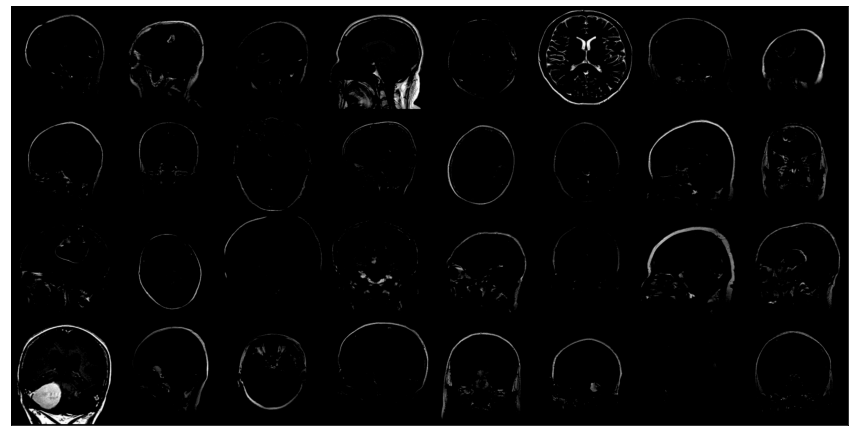

In [13]:
examples = iter(train_loader)
img,labels = examples.next()
def show_batch(dataset_loader):
    _, ax = plt.subplots(figsize=(15, 15))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(img).permute(1, 2, 0))
show_batch(train_loader)

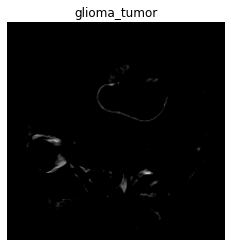

In [14]:
def show_image(img, label):
    plt.imshow(img.permute(1, 2, 0))
    plt.title(f'{dataset_training.classes[label]}')
    plt.axis("off")
    plt.show()

show_image(*dataset_training[11])

In [15]:
def training_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels) 
    return {'train_loss': loss,'train_acc':acc}

def validation_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    loss = F.cross_entropy(out, labels)  
    acc = accuracy(out, labels)  
    return {'val_loss': loss.detach(), 'val_acc': acc}

def validation_epoch_end(outputs):
    batch_losses = [x['val_loss'] for x in outputs]
    epoch_loss = torch.stack(batch_losses).mean() 
    batch_accs = [x['val_acc'] for x in outputs]
    epoch_acc = torch.stack(batch_accs).mean()  
    return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}

def epoch_end(epoch, result):
    print("Epoch [{}], time(s): {:.4f}, train_loss: {:.4f}, train_acc: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
        epoch, result['epoch_time'], result['train_loss'], result['train_acc'], result['val_loss'], result['val_acc']))

def test_step(model, batch):
    images, labels = batch
    if torch.cuda.is_available():
        images=images.to(device)
        labels=labels.to(device)
    out = model(images)  
    acc = accuracy(out, labels) 
    return {'y_test': labels, 'prediction': out}

def test_end(outputs, name):
    y_test = [y.item() for x in outputs for y in x['y_test'] ]
    y_prediction = [torch.argmax(y).item() for x in outputs for y in x['prediction']]
    
    report = classification_report(y_test, y_prediction, target_names=dataset_training.classes)
    print(f'Test {name} Pytorch')
    print(f'{report}')
    
    fig, ax = plt.subplots(figsize=(10, 10)) 
    ax.set_title(f'Confusion Matrix {name} Pytorch')
    cm = confusion_matrix(y_test,y_prediction)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=dataset_training.classes)
    disp.plot(cmap='Blues', ax=ax)

def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [16]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [validation_step(model, batch) for batch in val_loader]
    return validation_epoch_end(outputs)

@torch.no_grad()
def test(model, test_loader, name):
    model.eval()
    outputs = [test_step(model, batch) for batch in test_loader]
    return test_end(outputs, name)

def fit(epochs, lr, model, train_loader, val_loader, opt_func):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        t0 = time.time()
        model.train()
        train_losses = []
        train_accuracy = []
        for batch in train_loader:
            optimizer.zero_grad()
            outputs = training_step(model, batch)
            train_losses.append(outputs['train_loss'])
            train_accuracy.append(outputs['train_acc'])
            outputs['train_loss'].backward()
            optimizer.step()

        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['train_acc'] = torch.stack(train_accuracy).mean().item()
        result['epoch_time'] = time.time() - t0
        epoch_end(epoch, result)
        history.append(result)
    return history

In [17]:
def display_plot(history, name):
    acc = [epoch["train_acc"] for epoch in history]
    val_acc = [epoch["val_acc"] for epoch in history]

    loss = [epoch['train_loss'] for epoch in history]
    val_loss = [epoch['val_loss'] for epoch in history]

    plt.figure(figsize=(14, 8))
    tab_plot = [{
                "id": 1,
                "variables":[acc, val_acc],
                "labels":['Training Accuracy', 'Validation Accuracy'],
                "legend":'lower right',
                "title":f'Accuracy Pytorch - {name}',
                "ylabel":'Accuracy'
            },{ 
                "id": 2,
                "variables":[loss, val_loss],
                "labels":['Training Loss', 'Validation Loss'],
                "legend":'upper right',
                "title":f'Loss Pytorch - {name}',
                "ylabel":'Loss'
            }]
    

    epochs_range = range(25)
    for tab in tab_plot: 
        plt.subplot(1, 2, tab['id'])
        plt.plot(epochs_range,  tab['variables'][0], label=tab['labels'][0], marker='o', markerfacecolor='green',color='green')
        plt.plot(epochs_range , tab['variables'][1], label=tab['labels'][1], marker='o', markerfacecolor='blue',color='blue')
        plt.legend(loc=tab['legend'])
        plt.title(tab['title'])
        plt.xlabel('Epochs')
        plt.ylabel(tab['ylabel'])
    plt.show()

In [18]:
model_mobilenet_v2 = models.mobilenet_v2(pretrained=True)
model_mobilenet_v2.classifier[1] = nn.Linear(1280, 4)
model_mobilenet_v2.to(device)
model_mobilenet_v2.eval()

Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth


  0%|          | 0.00/13.6M [00:00<?, ?B/s]

MobileNetV2(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=1e-05, momen

In [19]:
opt_func = torch.optim.Adam
lr = 0.001
print('Train Mobilenetv2 Pytorch')
history_mobilenet_v2= fit(25, lr, model_mobilenet_v2, train_loader, val_loader, opt_func)

Train Mobilenetv2 Pytorch
Epoch [0], time(s): 29.2578, train_loss: 0.4384, train_acc: 0.8401, val_loss: 0.3512, val_acc: 0.8541
Epoch [1], time(s): 23.3451, train_loss: 0.1779, train_acc: 0.9448, val_loss: 0.1191, val_acc: 0.9686
Epoch [2], time(s): 23.1265, train_loss: 0.1527, train_acc: 0.9447, val_loss: 0.3079, val_acc: 0.9095
Epoch [3], time(s): 22.5832, train_loss: 0.1226, train_acc: 0.9637, val_loss: 0.6107, val_acc: 0.7986
Epoch [4], time(s): 23.1990, train_loss: 0.1066, train_acc: 0.9643, val_loss: 0.1329, val_acc: 0.9618
Epoch [5], time(s): 23.1318, train_loss: 0.0731, train_acc: 0.9745, val_loss: 0.2999, val_acc: 0.9270
Epoch [6], time(s): 22.6281, train_loss: 0.0709, train_acc: 0.9749, val_loss: 0.1017, val_acc: 0.9757
Epoch [7], time(s): 23.0915, train_loss: 0.0524, train_acc: 0.9809, val_loss: 0.0951, val_acc: 0.9618
Epoch [8], time(s): 23.3285, train_loss: 0.0335, train_acc: 0.9902, val_loss: 0.1093, val_acc: 0.9583
Epoch [9], time(s): 23.3322, train_loss: 0.0969, train_a

Test Mobilenetv2 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.91      0.29      0.44       100
meningioma_tumor       0.80      0.90      0.85       115
        no_tumor       0.61      0.97      0.75       105
 pituitary_tumor       0.95      0.84      0.89        74

        accuracy                           0.75       394
       macro avg       0.82      0.75      0.73       394
    weighted avg       0.81      0.75      0.73       394



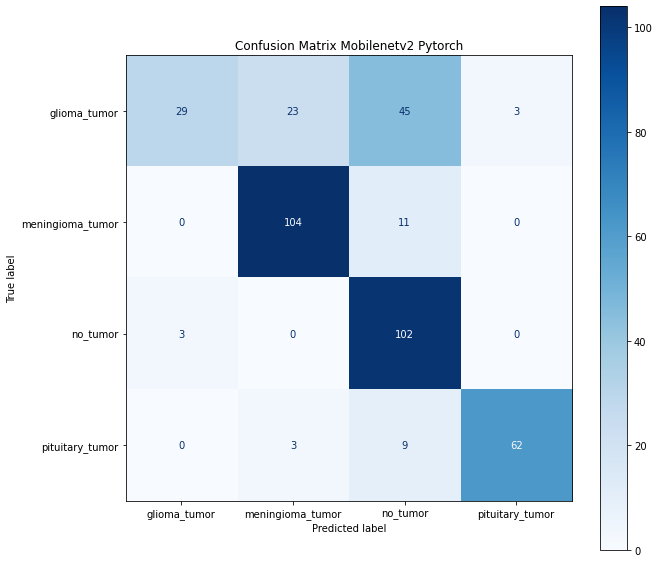

In [20]:
test(model_mobilenet_v2,test_loader, 'Mobilenetv2')

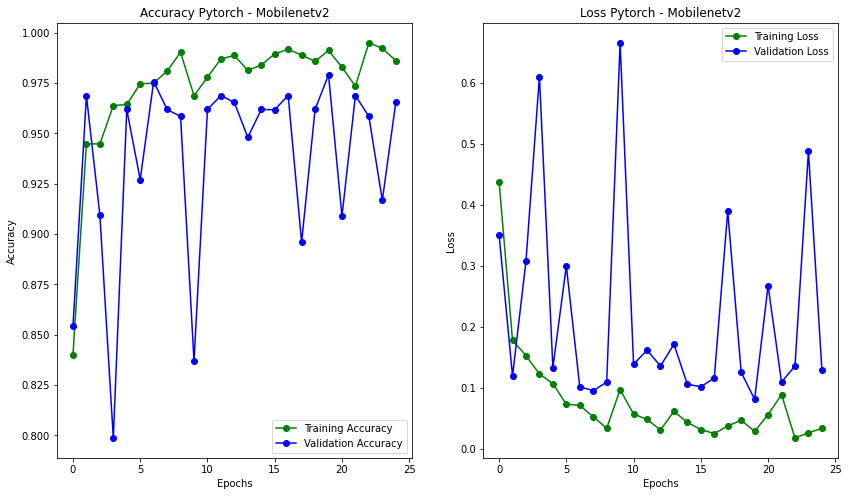

In [21]:
display_plot(history_mobilenet_v2, 'Mobilenetv2')

In [33]:
model_densenet121 = models.densenet121(pretrained=True)
model_densenet121.classifier = nn.Linear(1024, 4)
model_densenet121.to(device)
model_densenet121.eval()

DenseNet(
  (features): Sequential(
    (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu0): ReLU(inplace=True)
    (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (denseblock1): _DenseBlock(
      (denselayer1): _DenseLayer(
        (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu1): ReLU(inplace=True)
        (conv1): Conv2d(64, 128, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (norm2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu2): ReLU(inplace=True)
        (conv2): Conv2d(128, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      )
      (denselayer2): _DenseLayer(
        (norm1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu

In [34]:
print('Train DenseNet121 Pytorch')
history_densenet121 = fit(25, lr, model_densenet121, train_loader, val_loader, opt_func)

Train DenseNet121 Pytorch
Epoch [0], time(s): 32.9341, train_loss: 0.4317, train_acc: 0.8451, val_loss: 1.4554, val_acc: 0.5754
Epoch [1], time(s): 32.9678, train_loss: 0.2367, train_acc: 0.9083, val_loss: 0.6139, val_acc: 0.7914
Epoch [2], time(s): 32.9128, train_loss: 0.1481, train_acc: 0.9498, val_loss: 0.2292, val_acc: 0.9236
Epoch [3], time(s): 33.0030, train_loss: 0.1272, train_acc: 0.9519, val_loss: 0.2199, val_acc: 0.9167
Epoch [4], time(s): 32.8530, train_loss: 0.1367, train_acc: 0.9536, val_loss: 0.5172, val_acc: 0.8328
Epoch [5], time(s): 32.7249, train_loss: 0.1046, train_acc: 0.9655, val_loss: 0.6445, val_acc: 0.8021
Epoch [6], time(s): 32.9061, train_loss: 0.0759, train_acc: 0.9715, val_loss: 0.1545, val_acc: 0.9340
Epoch [7], time(s): 32.7801, train_loss: 0.0347, train_acc: 0.9880, val_loss: 0.0961, val_acc: 0.9647
Epoch [8], time(s): 32.8397, train_loss: 0.0759, train_acc: 0.9745, val_loss: 0.5938, val_acc: 0.8118
Epoch [9], time(s): 32.7463, train_loss: 0.1027, train_a

Test DenseNet121 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.88      0.21      0.34       100
meningioma_tumor       0.74      1.00      0.85       115
        no_tumor       0.65      0.96      0.78       105
 pituitary_tumor       0.95      0.76      0.84        74

        accuracy                           0.74       394
       macro avg       0.80      0.73      0.70       394
    weighted avg       0.79      0.74      0.70       394



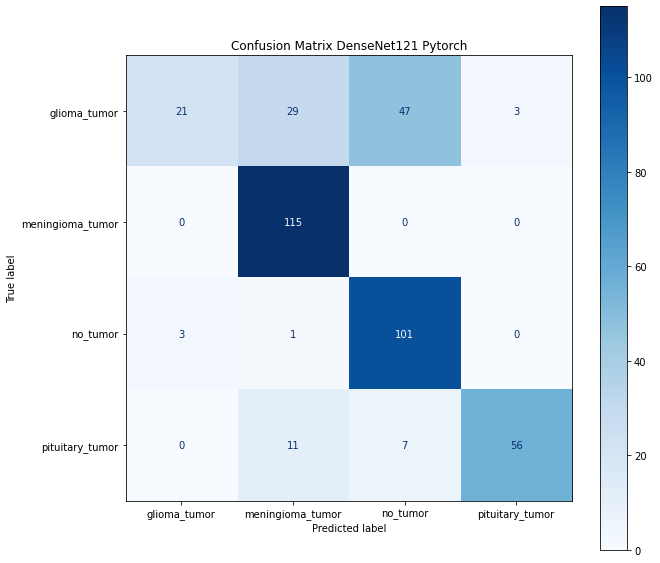

In [37]:
test(model_densenet121,test_loader, 'DenseNet121')

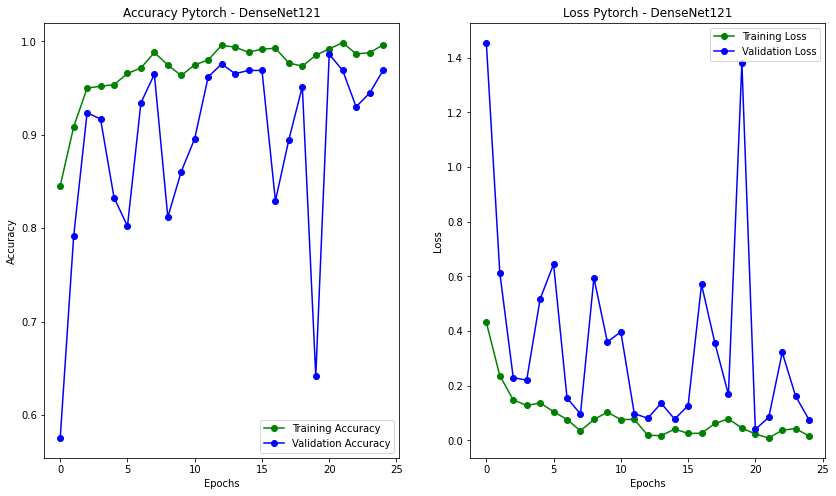

In [38]:
display_plot(history_densenet121, 'DenseNet121')

In [46]:
model_resnet50 = models.resnet50(pretrained=True)
model_resnet50.fc = nn.Linear(2048, 4)
model_resnet50.to(device)
model_resnet50.eval()

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): Bottleneck(
      (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
      (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (downsample): Sequential(
        (0): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 

In [47]:
print('Train Resnet50 Pytorch')
history_resnet50 = fit(25, lr, model_resnet50, train_loader, val_loader, opt_func)

Train Resnet50 Pytorch
Epoch [0], time(s): 30.0596, train_loss: 0.6261, train_acc: 0.7556, val_loss: 1.6958, val_acc: 0.6041
Epoch [1], time(s): 29.7777, train_loss: 0.3250, train_acc: 0.8828, val_loss: 2.8618, val_acc: 0.3646
Epoch [2], time(s): 29.9879, train_loss: 0.2583, train_acc: 0.9058, val_loss: 1.0464, val_acc: 0.6378
Epoch [3], time(s): 29.8879, train_loss: 0.2221, train_acc: 0.9206, val_loss: 0.2980, val_acc: 0.8853
Epoch [4], time(s): 29.9193, train_loss: 0.2118, train_acc: 0.9291, val_loss: 1.9998, val_acc: 0.5046
Epoch [5], time(s): 29.8194, train_loss: 0.1758, train_acc: 0.9390, val_loss: 0.6207, val_acc: 0.7591
Epoch [6], time(s): 29.4974, train_loss: 0.1158, train_acc: 0.9597, val_loss: 0.5023, val_acc: 0.8742
Epoch [7], time(s): 29.9533, train_loss: 0.1383, train_acc: 0.9534, val_loss: 0.2835, val_acc: 0.9132
Epoch [8], time(s): 29.6497, train_loss: 0.0848, train_acc: 0.9722, val_loss: 0.2038, val_acc: 0.9374
Epoch [9], time(s): 29.9385, train_loss: 0.0596, train_acc:

Test Resnet50 Pytorch
                  precision    recall  f1-score   support

    glioma_tumor       0.92      0.24      0.38       100
meningioma_tumor       0.76      0.98      0.86       115
        no_tumor       0.66      1.00      0.80       105
 pituitary_tumor       0.89      0.74      0.81        74

        accuracy                           0.75       394
       macro avg       0.81      0.74      0.71       394
    weighted avg       0.80      0.75      0.71       394



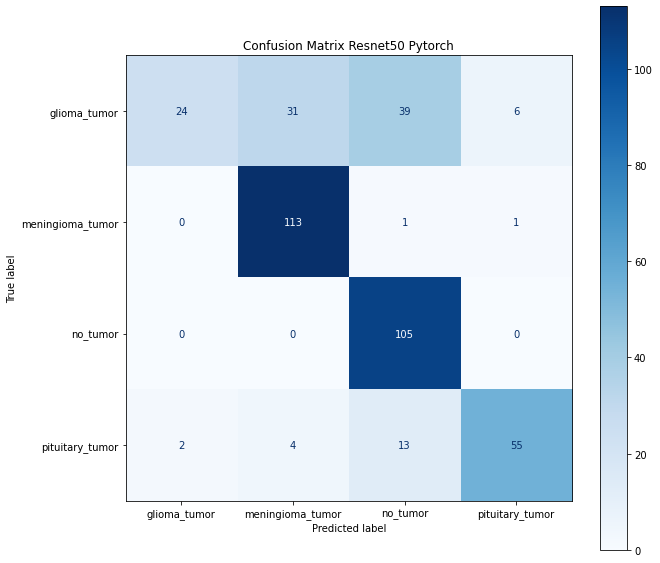

In [49]:
test(model_resnet50,test_loader, 'Resnet50')

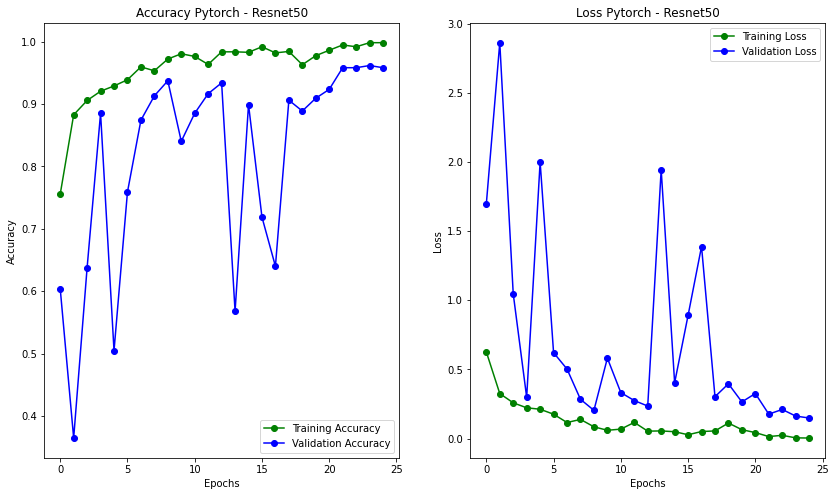

In [50]:
display_plot(history_resnet50, 'Resnet50')